# Visualize Attention Maps

This notebook focuses on visualizing attention maps from different models for the same input image.

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
import torch.nn.functional as nnF
import torchvision.transforms.functional as F
import torchvision.transforms as pth_transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("white", {
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
        'Droid Sans',
        'sans-serif'
    ],
})

%matplotlib inline
# import seaborn as sns
# sns.set()

from sparse_detector.configs import (
    build_dataset_config,
    build_detr_config,
    load_config
)
from sparse_detector.models import build_model
import sparse_detector.datasets.transforms as T
from sparse_detector.visualizations import ColorPalette
from sparse_detector.datasets.coco import CLASSES, NORMALIZATION
from sparse_detector.utils.box_ops import rescale_bboxes

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda")

**Sample image**

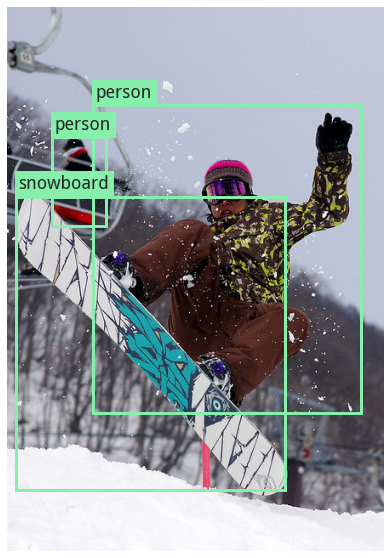

In [5]:
image_id = 491130
image_path = Path(package_root) / "data" / "COCO" / "val2017" / (f"{image_id}".rjust(12, "0") + ".jpg")
image = Image.open(image_path)

box_annotations = [
    {'bbox': [100.67, 115.06, 314.97, 362.42], 'category': 'person'},
    {'bbox': [10.07, 222.92, 316.4, 345.17], 'category': 'snowboard'},
    {'bbox': [52.49, 152.53, 62.78, 104.91], 'category': 'person'}
]

fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(image)
ax.axis('off')

COLOR = '#86efac'
for ann in box_annotations:
    category = ann['category']
    xmin, ymin, width, height = ann['bbox']
    rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=COLOR, fill=False, linewidth=3)
    ax.add_artist(rect)
    
    
    ax.text(xmin+3, ymin-9, category, fontsize=18, bbox=dict(facecolor=COLOR, edgecolor=COLOR))

In [6]:
device = torch.device('cuda')

def load_model(config_file_name, model_checkpoint_dir):
    detr_config_file = Path(package_root) / "configs" / config_file_name
    base_config = load_config(Path(package_root) / "configs" / "base.yml")
    detr_config = build_detr_config(detr_config_file, params=None, device=device)

    # Surgery for path
    dataset_config = build_dataset_config(base_config["dataset"], params=None)
    dataset_config['coco_path'] = Path(package_root) / "data" / "COCO"

    detr_config["average_cross_attn_weights"] = True

    # Build model
    model, _, _ = build_model(**detr_config)
    resume_from_checkpoint = Path(package_root) / "checkpoints" / model_checkpoint_dir / "checkpoint.pth"
    checkpoint = torch.load(resume_from_checkpoint, map_location="cpu")
    model.load_state_dict(checkpoint["model"])
    model.eval()
    model.to(device)
    return model, detr_config, dataset_config

In [8]:
softmax_model, softmax_config, dataset_config = load_model("detr_baseline.yml", "v2_baseline_detr")
# sparsemax_model, _, _ = load_model("decoder_sparsemax_baseline.yml", "v2_decoder_sparsemax")
# entmax_model, _, dataset_config = load_model("decoder_entmax15_baseline.yml", "v2_decoder_entmax15")
# alpha_entmax_model, _, _ = load_model("decoder_alpha_entmax.yml", "v2_decoder_alpha_entmax")

Cross-attention activation: softmax; average attention weights: True
Transformer.reset_parameters()


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [84]:
import torchvision.transforms as pth_transforms

resize_transform = T.RandomResize([800], max_size=1333)
resize_image, _ = resize_transform(img)

transforms = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(NORMALIZATION["mean"], NORMALIZATION["std"]),
])

input_tensor = transforms(resize_image).unsqueeze(0).to(device)
input_tensor.shape

torch.Size([1, 3, 800, 1120])

In [177]:
def get_specific_attention_for_model(model):
    # use lists to store the outputs via up-values
    conv_features, dec_attn_weights = [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    # propagate through the model
    outputs = model(input_tensor)
    for hook in hooks:
        hook.remove()

    conv_features = conv_features[0]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    # Here we get the feature from the last block in the last layer of ResNet backbone
    h, w = conv_features['3'].tensors.shape[-2:]

    pred_logits = outputs['pred_logits'].detach().cpu()
    pred_boxes = outputs['pred_boxes'].detach().cpu()

    probas = pred_logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    bboxes = rescale_bboxes(pred_boxes[0, keep], img.size)
    queries = keep.nonzero()

    selected_query = queries[-1]
    attn_map = dec_attn_weights[0, selected_query].view(h, w).detach().cpu().numpy()

    return attn_map, queries, bboxes, probas
# attn_map = dec_attn_weights[0, queries[0]].view(h, w).detach().cpu().numpy()

In [182]:
attn_map, queries, bboxes, probas = get_specific_attention_for_model(sparsemax_model)

In [183]:
queries

tensor([[56],
        [82]])

In [184]:
query = queries[-1].item()
predicted_label = probas[query].argmax()
predicted_prob = probas[query, predicted_label]
probability = predicted_prob * 100

title = f"Query {query}; Predicted label: {CLASSES[predicted_label]} - {probability:.2f}%"
title
# for query in queries:
#     predicted_label = probas[query].argmax()
#     predicted_prob = probas[query, predicted_label]
#     print(CLASSES[predicted_label], predicted_prob)

'Query 82; Predicted label: bird - 99.66%'

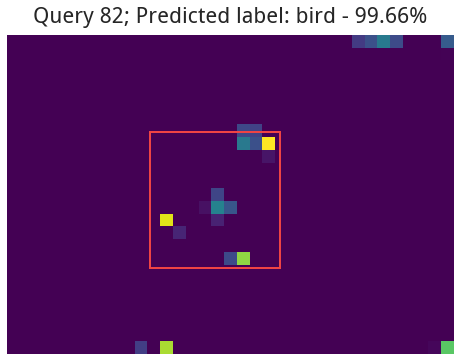

In [186]:
def rescale_bboxes_for_ax(bbox, img_size, canvas_size):
    """
    Rescale the predicted bounding boxes for visualization on the attention maps
    """
    imw, imh = img_size
    cw, ch = canvas_size
    w_scale, h_scale = imw * 1.0 / cw, imh * 1.0 / ch
    xmin, ymin, xmax, ymax = bbox
    b = (xmin * 1.0 / w_scale, ymin * 1.0 / h_scale, xmax * 1.0 / w_scale, ymax * 1.0 / h_scale)
    return b

def show_attn_map(attn_map, bboxes, title=None, file_name=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(attn_map, cmap='viridis')
    ax.grid(False)
    ax.axis('off')

    bbox = bboxes[-1]
    (xl_min, xl_max) = ax.get_xlim()
    (yl_max, yl_min) = ax.get_ylim()
    c_w = abs(xl_min) + abs(xl_max)
    c_h = abs(yl_min) + abs(yl_max)
    imw, imh = img.size
    bbox = rescale_bboxes_for_ax(bbox, (imw, imh), (c_w, c_h))

    xmin, ymin, xmax, ymax = bbox
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                    fill=False, color=ColorPalette.RED, linewidth=2, zorder=1000, axes=ax)
    ax.add_artist(rect)
    if title:
        ax.set_title(title, fontsize=22, pad=12)
    fig.subplots_adjust(wspace=0, hspace=0)

    # if file_name:
    #     fig.savefig(f"images/attn_viz/{file_name}.png", bbox_inches="tight")
    #     fig.savefig(f"images/attn_viz/{file_name}.pdf", bbox_inches="tight")

show_attn_map(attn_map, bboxes, title, "sparsemax")